In [328]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [329]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
# sns.set_context("poster")
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Loading the json file to a pandas dataframe

In [330]:
json_list = json.load(open('uber_data_challenge.json'))
df = pd.DataFrame(json_list)
print df.shape
df[:3]

(50000, 12)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0


### Preprocessing phase

In [331]:
df = df.convert_objects(convert_numeric=coerce, convert_dates=coerce, copy=False, convert_timedeltas=coerce)
df.last_trip_date

0        2014-06-17
1        2014-05-05
2        2014-01-07
3        2014-06-29
4        2014-03-15
5        2014-06-06
6        2014-01-25
7        2014-01-29
8        2014-02-01
9        2014-01-05
10       2014-05-30
11       2014-01-10
12       2014-03-12
13       2014-06-08
14       2014-01-28
15       2014-01-16
16       2014-06-28
17       2014-07-01
18       2014-06-24
19       2014-06-03
20       2014-03-16
21       2014-04-29
22       2014-05-02
23       2014-06-13
24       2014-05-18
25       2014-01-03
26       2014-01-22
27       2014-03-05
28       2014-06-08
29       2014-02-27
            ...    
49970    2014-04-14
49971    2014-06-14
49972    2014-06-29
49973    2014-06-28
49974    2014-01-18
49975    2014-06-18
49976    2014-07-01
49977    2014-01-09
49978    2014-05-03
49979    2014-04-07
49980    2014-01-20
49981    2014-03-16
49982    2014-04-24
49983    2014-02-26
49984    2014-01-26
49985    2014-02-25
49986    2014-05-23
49987    2014-05-31
49988    2014-06-14


In [332]:
print 'verifying date-bounds...'
print '=' * 40
print 'last_trip_date'
print 'most recent trip -- ', df.last_trip_date.max()
print 'earliest trip -- ', df.last_trip_date.min()
print '=' * 40
print 'signup_date'
print 'most recent trip -- ', df.signup_date.max()
print 'earliest trip in -- ', df.signup_date.min()

#converting fields from str -> datetime obj
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date )


most_recent_ride_date_minus_30days = df.last_trip_date.max() - pd.offsets.Day(30)
churned_cohort = df[df.last_trip_date < most_recent_ride_date_minus_30days]
still_active_cohort = df[~(df.last_trip_date < most_recent_ride_date_minus_30days)]

# just save any confusion converting this boolean to binary
df['uber_black_user'] = df.uber_black_user.astype(int)

#fill in with median
df['avg_rating_by_driver'].fillna(value=df['avg_rating_of_driver'].median(), inplace=True)
df['avg_rating_of_driver'].fillna(value=df['avg_rating_of_driver'].median(), inplace=True)

verifying date-bounds...
last_trip_date
most recent trip --  2014-07-01
earliest trip --  2014-01-01
signup_date
most recent trip --  2014-01-31
earliest trip in --  2014-01-01


In [333]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,5.796827,4.778648,4.650038,1.074764,8.849536,2.278200,0.37708,60.926084
std,5.707357,0.445820,0.575601,0.222336,19.958811,3.792684,0.48466,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,0.00000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,0.00000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,1.00000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,1.00000,100.000000


### EDA

''

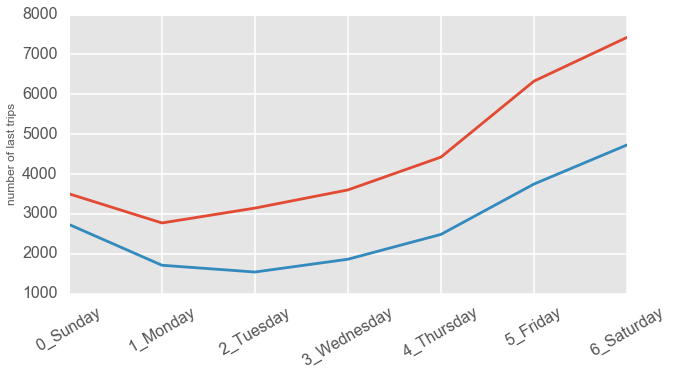

In [334]:
pylab.rcParams['figure.figsize'] = (10, 5)

day_of_week_name = {
    0:'0_Sunday',
    1:'1_Monday',
    2:'2_Tuesday',
    3:'3_Wednesday',
    4:'4_Thursday',
    5:'5_Friday',
    6:'6_Saturday',
}

f_day_conv = lambda x: day_of_week_name[x.dayofweek]

churned_cohort.last_trip_date.apply(f_day_conv).value_counts().sort_index().plot()
still_active_cohort.last_trip_date.apply(f_day_conv).value_counts().sort_index().plot()
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
ylabel('number of last trips')
;

### On what week day was the last trip most frequent?

Seperating active and churned users we can inspect their weekday usage in the context of last trip. There isn't much difference between active users and churned users here.

''

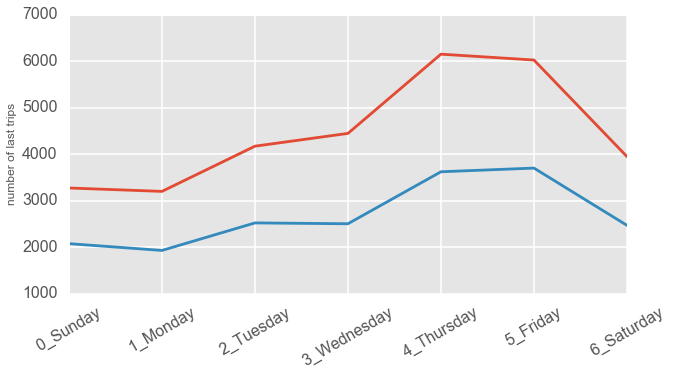

In [335]:
churned_cohort.signup_date.apply(f_day_conv).value_counts().sort_index().plot()
still_active_cohort.signup_date.apply(f_day_conv).value_counts().sort_index().plot()
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
ylabel('number of last trips')
;

I also wanted to see if there was a difference between the two groups in terms of sign-in dates by week day. Both of the groups seem to exhibit the same behavior in terms of weekday sign-ups, last-trips, and general usage (likely).

In [336]:
def plot_t_series_last_sign_up(cohort, city_name=None):
    '''
    I:DataFrame, city name (string)
    O:None, just plots the daily resampled value of the time-series
    '''
    if city_name:
        cohort = cohort[churned_cohort.city == city_name]
    cohort_t_series = cohort[['last_trip_date']]
    cohort_t_series['count'] = 1
    cohort_t_series.index = cohort_t_series.last_trip_date
    del cohort_t_series['last_trip_date']

    # time-frame it by window
    cohort_t_series.resample('D', how='sum').plot()
    ylabel('number of last sign-ins')
    if city_name: 
        title(city_name)
    else:
        title('All Cities')
    ;


,count
last_trip_date,
2014-01-31,10147
2014-02-28,4308
2014-03-31,4568
2014-04-30,4588
2014-05-31,7585


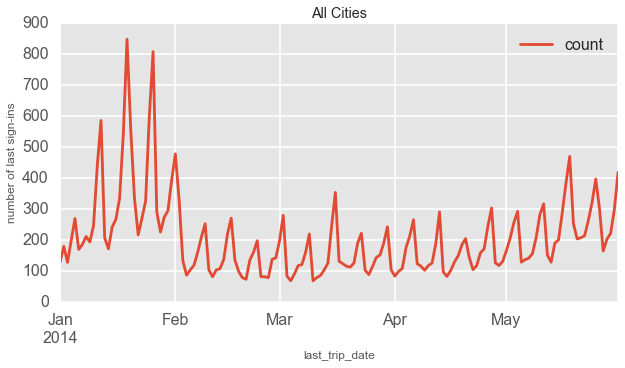

In [337]:
plot_t_series_last_sign_up(churned_cohort)
churned_cohort_t_series = churned_cohort[['last_trip_date']]
churned_cohort_t_series['count'] = 1
churned_cohort_t_series.index = churned_cohort_t_series.last_trip_date
del churned_cohort_t_series['last_trip_date']
churned_cohort_t_series.resample('M', how='sum')

It's quite clear that January experienced the most churn and the other peak is a the opposite end. There's a steady rate in the middle of months names Febuary, March, March, April. The jagged pattern of the plot is a result of the weekly usage trends. People tend to use Uber much more closer to the weekend.

###Why would we be seeing such a trend?
- Promotions in January?
- Duration of usage might have lead users to seek something else

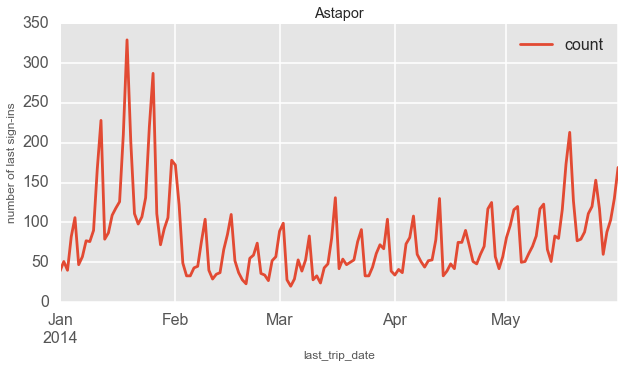

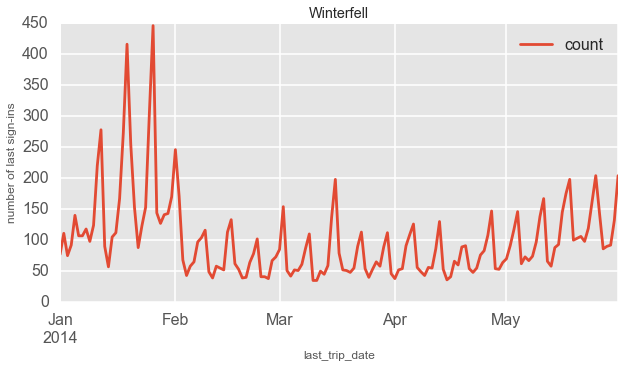

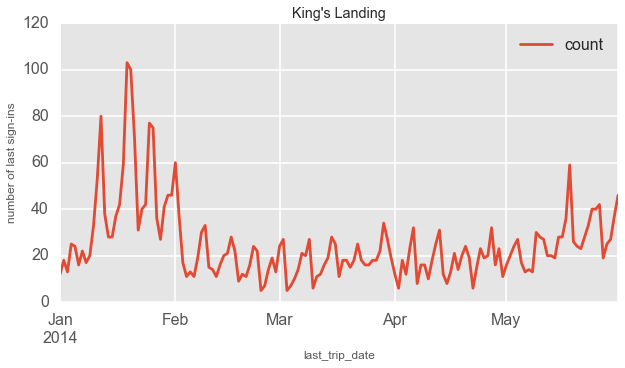

In [338]:
plot_t_series_last_sign_up(churned_cohort, 'Astapor')
plot_t_series_last_sign_up(churned_cohort, 'Winterfell')
plot_t_series_last_sign_up(churned_cohort, "King's Landing")

Taking a more granular look by stratifying city-by-city, the still trend holds. Users mostly churn within the first most of sign-up.

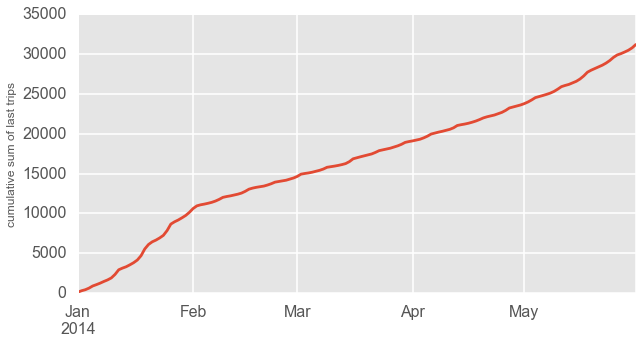

In [339]:
churned_cohort.last_trip_date.value_counts().sort_index().cumsum().plot()
ylabel('cumulative sum of last trips');

The cumulative sum of all the last trips shows the same trend as illustrated by the steeper slope of the curve in January. Relative to the rest of the months were the rate seems to be constant.

,still_active,churned,pct_retained
Astapor,4228,12306,25.6%
Winterfell,8213,15123,35.2%
All cities,18804,31196,37.6%
King's Landing,6363,3767,62.8%


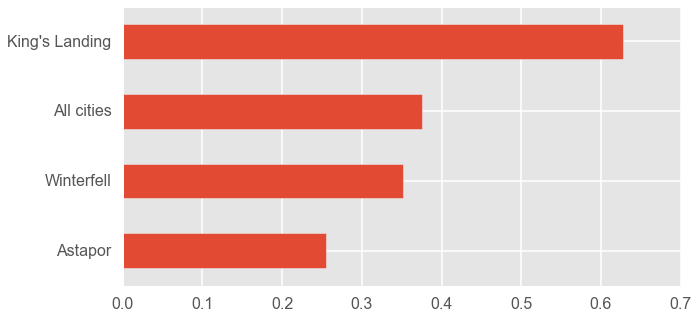

In [340]:
df_concated = pd.concat([still_active_cohort.city.value_counts(), churned_cohort.city.value_counts()], axis=1)
df_concated.columns = ['still_active', 'churned']

df_temp = pd.DataFrame({'All cities':(df_concated['still_active'].sum(),df_concated['churned'].sum())}).T
df_temp.rename(columns={1:'churned', 0:'still_active'}, inplace=True)
df_concated = pd.concat([df_concated, df_temp], axis=0)

df_concated['pct_retained'] = df_concated['still_active'] / (df_concated['churned'] +  df_concated['still_active'])
df_concated.sort(columns='pct_retained', inplace=True)

df_concated['pct_retained'].plot(kind='barh')

#formatting
df_concated['pct_retained'] = df_concated['pct_retained'].apply(lambda x: str(round(x,3) * 100) + '%' )
df_concated

### What fraction of the observed users were retained?


Users retained overall is 37.6% however if we stratify city-by-city we notice King's Landing as dominating retained users. I'm curious to figure out as to why this is? Could it be lack of competitors in the area, better promoting and marketing, etc...

,Regular,Uber Black
active_users,9497,9307
churned_users,21839,9357


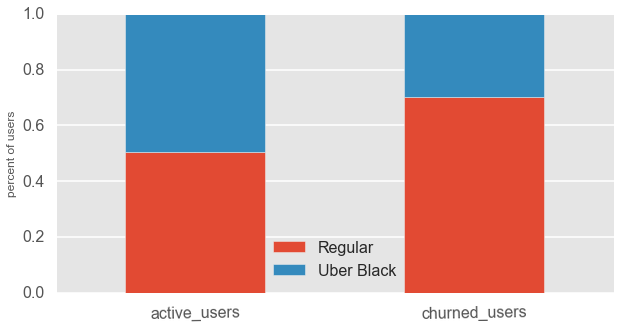

In [341]:
df_user_black_plot = pd.DataFrame(zip(still_active_cohort.uber_black_user.value_counts(), churned_cohort.uber_black_user.value_counts()), columns=['active_users', 'churned_users']).T
df_user_black_plot.rename(columns={0:'Regular', 1:'Uber Black'}, inplace=True)
df_user_black_plot.apply(lambda row: row / (row['Regular'] + row['Uber Black']), axis=1).plot(kind='bar',stacked=True,rot=1)
ylabel('percent of users')
df_user_black_plot

### Uber Black Users Stick Around longer

One notable difference between in the two groups is proportion of Uber Black users. The Active cohort seems to have a significantly Uber Black user base. Perhaps it's a good future predictor of whether or not a user will be retained. Maybe we should also consider getting more regular users to switch to Uber Black. Or simply study the user base better and understand what differentiates them from regular users. Black users also tended to favor the iphone versus android. 

In [342]:
# for users that have dropped off what's the average rating they've given
# are they mostly android or iphone users
# black users

print churned_cohort.avg_dist.median()
print churned_cohort.weekday_pct.median()
print churned_cohort.avg_rating_by_driver.median()
print churned_cohort.avg_rating_of_driver.median()
print churned_cohort.surge_pct.median()
print churned_cohort.phone.value_counts()
print churned_cohort.uber_black_user.value_counts()

print still_active_cohort.avg_dist.median()
print still_active_cohort.weekday_pct.median()
print still_active_cohort.avg_rating_by_driver.median()
print still_active_cohort.avg_rating_of_driver.median()
print still_active_cohort.surge_pct.median()
print still_active_cohort.phone.value_counts()
print still_active_cohort.uber_black_user.value_counts()


4.03
69.6
5.0
5.0
0.0
iPhone     19057
Android    11876
Name: phone, dtype: int64
False    21839
True      9357
Name: uber_black_user, dtype: int64
3.73
64.3
4.8
4.8
0.0
iPhone     15525
Android     3146
Name: phone, dtype: int64
True     9497
False    9307
Name: uber_black_user, dtype: int64


In [343]:
#throw it away or use it

print churned_cohort.avg_dist.mean()
print churned_cohort.weekday_pct.mean()
print churned_cohort.avg_rating_by_driver.mean()
print churned_cohort.avg_rating_of_driver.mean()
print churned_cohort.surge_pct.mean()
print churned_cohort.phone.value_counts()
print churned_cohort.uber_black_user.value_counts()

print still_active_cohort.avg_dist.mean()
print still_active_cohort.weekday_pct.mean()
print still_active_cohort.avg_rating_by_driver.mean()
print still_active_cohort.avg_rating_of_driver.mean()
print still_active_cohort.surge_pct.mean()
print still_active_cohort.phone.value_counts()
print still_active_cohort.uber_black_user.value_counts()

6.20793851776
60.6470316707
4.78746414875
4.60755686878
8.66673932555
iPhone     19057
Android    11876
Name: phone, dtype: int64
False    21839
True      9357
Name: uber_black_user, dtype: int64
5.11478834291
61.389034248
4.76277173913
4.59293035174
9.15279727718
iPhone     15525
Android     3146
Name: phone, dtype: int64
True     9497
False    9307
Name: uber_black_user, dtype: int64


In [344]:
def feature_importance(feature_names, model, top=10):
    '''
    Plotting top x most important features
    
    I: Feature Matrix (DataFrame), model, labels (y), top x
    O: Bar plot of most normalized by the most important feature
    '''
    
    #Grabbing names of the features
    feature_importance_series = pd.Series(model.feature_importances_, index=feature_names)
    feature_importance_series /= feature_importance_series.max()
    feature_importance_series.sort()
    
    #parsing the model date
    model_name = str(model).split('(')[0]

    # create a figure of given size
    # arg to play with the size: figsize=(25,25)
    fig = plt.figure(figsize=(9, 9))

    # add a  subplot
    ax = fig.add_subplot(111)
    
    plt.title(model_name)
    feature_importance_series[::-1][:top][::-1].plot(kind='barh')    
    pass


In [345]:
def dummy_it(input_df):
    '''
    I: Pandas DataFrame with categorical features
    O: Same df with binarized categorical features
    '''
    
    # base_case empty DF to append to
    base_case_df = pd.DataFrame() 
    categorical_variables = []
    
    # every column that's not a categorical column, we dummytize
    for col in input_df.columns:
        if input_df[col].dtype in ['float64','int64','bool']:
            base_case_df = pd.concat([base_case_df, input_df[col]], axis=1)
        else:
            base_case_df = pd.concat([base_case_df, pd.get_dummies(input_df[col])], axis=1)
            categorical_variables.append(col)
    
    # print out all the categoricals which are being dummytized
    if categorical_variables: 
        print 'Variables Being Dummytized: '
        print '=' * 10
        print '\n'.join(categorical_variables)

    return base_case_df

In [346]:
def get_scores_cross_val(model_obj, feature_M, labels):
    '''
    I: persisted model object, feature matrix (numpy or pandas datafram), labels
    O: 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'
    '''
    scoring_types = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    score_stor = [model_cv_score(model_obj, feature_M, labels, scoring=score_type) for score_type in scoring_types]
    model_name = str(model_obj).split('(')[0]
    df_output = pd.DataFrame(score_stor, index=scoring_types).T
    df_output.index = [model_name]
    return df_output

In [347]:
def model_cv_score(model, feat_matrix, labels, folds=10, scoring='roc_auc'):
    '''
    I: persisted model object, feature matrix (numpy or pandas datafram), labels, k-folds, scoring metric
    O: mean of scores over each k-fold (float)
    '''
    return np.mean(cross_validation.cross_val_score(model, feat_matrix, labels, cv=folds, scoring=scoring))

## More Preprocessing 

In [348]:
# labeling the data
# Per definition: we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

df['retained_or_not'] = df.last_trip_date.apply(lambda x: int(x > most_recent_ride_date_minus_30days))
df[['retained_or_not', 'last_trip_date']][:3]

,retained_or_not,last_trip_date
0,1,2014-06-17
1,0,2014-05-05
2,0,2014-01-07


In [349]:
drop_fields = [
    'last_trip_date',
    'signup_date',
    'retained_or_not' # label 
]

#NOTE -- would practice k-1 dummies 
#to avoid dummy variable if linear model is being used
X = dummy_it(df.drop(drop_fields, axis=1))
y = df['retained_or_not']

#Scale 0 mean & unit variance
scaler = StandardScaler()

binary_fields = [
    'Astapor',
    "King's Landing",
    'Winterfell',
    'Android',
    'iPhone',
    'uber_black_user',
]
X_scaled = scaler.fit_transform(X.drop(binary_fields, axis=1))
X_scaled_w_cats = np.c_[X_scaled, X[binary_fields].as_matrix()]


Variables Being Dummytized: 
city
phone


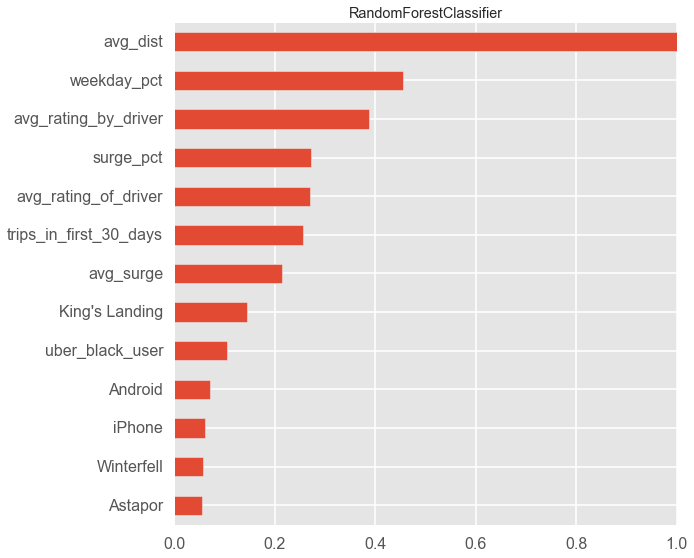

In [350]:
# need to maintain order of the fields names
feat_names = list(X.drop(binary_fields, axis=1).columns) + binary_fields
clf_RF = RandomForestClassifier(random_state=42)
clf_RF.fit(X_scaled_w_cats, y) 
feature_importance(feat_names, clf_RF, top=len(feat_names))

#### EXTRA CREDIT Build a predictive model to help Uber determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. 

My motivation for chosing Random Forest is that's a non-linear classifier that works well out-of-the-box and provides excellent results. The need for a non-linear wasn't apparent though it was a nice-to-have should there be a non-linear manifold between the predictors or multicollinearity. It also has an easy to use feature importance attribute (_Shown above_).

Random Forest ranks feature importance by information gain. After fitting the classifier to the entire dataset (no hold out) the ML algorithm ranks average distance the user has traveled to the be the strongest feature. It's careful to note that this only shows the features as they relate to one another i.e. it's not stating that it only needs average distance to make predictions.  

Another good alternative is Logistic Regression. It works well if the data is linearly seperable and there's no multicollinearity. Given more time, I sure would've done a grid-search to tune model to perfection and ensure that it generalizes with new data well.


In [351]:
#K-folds cross validation
roc_plot(X_train, y_train, X_test, y_test, RandomForestClassifier)
get_scores_cross_val(clf_RF, X_scaled_w_cats, y)

ValueError: Unknown label type: array([[  1.],
       [  0.],
       [  0.],
       ..., 
       [  1.],
       [ nan],
       [  1.]])

In [357]:
#test_train split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_w_cats, 
        y, 
        test_size=.20, 
        random_state=42
)

y_train[-5:]

11284    0
44732    1
38158    1
860      0
15795    1
Name: retained_or_not, dtype: int64

In [358]:
y_ = y_train.copy()
X_ = X_train.copy()

print len(y_)
kf = KFold(len(y_), n_folds=5, shuffle=True)
for i, (train_index, test_index) in enumerate(kf):

    # Splitting the folds in the data for Cross-Val set
    X_train_, X_test = X_[train_index], X_[test_index]
    print np.max(train_index)
    y_train_ = y_[train_index]
    
    print y_train_.shape, y_train_.dropna().shape
    break

print y_[train_index][:5], y_[0]
# print type(train_index)
train_index[:5], np.max(train_index), len((train_index))

40000
39999
(32000,) (25618,)
0    1.0
1    0.0
2    0.0
3    1.0
4    NaN
Name: retained_or_not, dtype: float64 1


(array([0, 1, 2, 3, 4]), 39999, 32000)

In [366]:
y_train[train_index[:5]], y_[train_index[:5]], train_index[:5], y_train[[0,4]]

(0    1.0
 1    0.0
 2    0.0
 3    1.0
 4    NaN
 Name: retained_or_not, dtype: float64, 0    1.0
 1    0.0
 2    0.0
 3    1.0
 4    NaN
 Name: retained_or_not, dtype: float64, array([0, 1, 2, 3, 4]), 0    1.0
 4    NaN
 Name: retained_or_not, dtype: float64)

In [ ]:
y_

In [105]:
def roc_plot(X, y, X_hold_out, y_hold_out, clf_class, **kwargs):
    '''
    I: Feature Matrix, labels, model, hyper-parameter settings
    O: None, it plots a ROC of the Cross-Validation set
    '''
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    kf = KFold(len(y), n_folds=5, shuffle=True)
    
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    plt.figure(figsize=(10,10))
    
    
    for i, (train_index, test_index) in enumerate(kf):
        
        # Splitting the folds in the data for Cross-Val set
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # Model fitting
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        
        # Used for mean roc plot
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Drawing the curve
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    #plot the holdout
    y_prob_hold_out = clf.predict_proba(X_hold_out)
    fpr, tpr, thresholds = roc_curve(y_hold_out, y_prob_hold_out[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'r-.', lw=2, label='ROC hold out (area = %0.2f)' % roc_auc)
     
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.show()



### How valid is your model? Include any key indicators of model performance.

The area under the curve of the ROC is what I normally use to evaluate the model. It's a great metric for simplying saying my model is 81% chance of predicting correctly on a new point. However, it also depends on use-case and your tolerance for type I or type II errors. In which case, we would optimize for precision or recall.

To ensure that I'm not getting this scores by random chance, K-fold cross-validation where data is fitted and scored on random parts of the data K times. Where K is between 4-10 (rule-of-thumb in machine learning). 

Beyond that I've also made a hold out set to score the model on. My motivation for this technique is that I like to tune the model to perfection using K-fold and after that's done I'll score it on the hold out which is 10-20 percent of the data set (chose at random).

#### Give more time--
- engineer a feature that captures the tenure for each user
- show how varying the distance and all else equal, actually changes the probability through a plot